# 📝 **Exploring interpretability: GLM and GAM**  

The objective of this notebook is to analyze the results of GLM and GAM focusing on interpretability. For this,  we will explore methods like Feature Importance, partial dependence plot and SHapley Additive exPlanations (SHAP). It´s important to notice that the results and optimizations considered here are explicated in ``Optuna_Results_Analysis_IT_GLM_GAM_SR`` file. 

***

### 📚 **Importing libraries & Data**

In [1]:
import optuna

import pandas as pd
import numpy as np
import math
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.cluster import Birch

from statsmodels.genmod.families.links import Identity

c:\Users\julia24002\.conda\envs\glm_gam\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#!pip install seaborn

In [3]:
df = pd.read_csv("../data/train.csv")
display(df)

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.00
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.00
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.00
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.00
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21258,4,106.957877,53.095769,82.515384,43.135565,1.177145,1.254119,146.88130,15.504479,65.764081,...,3.555556,3.223710,3.519911,1.377820,0.913658,1,2.168889,0.433013,0.496904,2.44
21259,5,92.266740,49.021367,64.812662,32.867748,1.323287,1.571630,188.38390,7.353333,69.232655,...,2.047619,2.168944,2.038991,1.594167,1.337246,1,0.904762,0.400000,0.212959,122.10
21260,2,99.663190,95.609104,99.433882,95.464320,0.690847,0.530198,13.51362,53.041104,6.756810,...,4.800000,4.472136,4.781762,0.686962,0.450561,1,3.200000,0.500000,0.400000,1.98
21261,2,99.663190,97.095602,99.433882,96.901083,0.690847,0.640883,13.51362,31.115202,6.756810,...,4.690000,4.472136,4.665819,0.686962,0.577601,1,2.210000,0.500000,0.462493,1.84


### 📊 **Target distribution for clustering (GLM)** 

For analysis the results in clustering for GLM, we can plot the target distribution for each group. For the that, it´s necessary to train the Birch with the params discovered by Optuna and the same data used in optimization process.

First of all, it´s necessary to make the train test split, using the same seed and test size.

In [4]:
TEST_SIZE = 0.1

In [5]:
X = df.drop(columns="critical_temp")
y = df["critical_temp"]
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=1702
    )
y_test = np.clip(y_test, 1e-6, None)
y_train = np.clip(y_train, 1e-6, None)

After that we can import the params of the Optuna best trial.

In [6]:
study_name = "optimization_clusters_glm_teste21_07_2025_16_46_28"
storage_url = "sqlite:///../Optuna_files/optimization_glm_bayesian.db"

study_glm = optuna.load_study(study_name=study_name, storage=storage_url)

In [7]:
study_glm.best_params

{'clusterer': 'birch',
 'n_clusters_birch': 10,
 'branching_factor': 700,
 'threshold': 0.18251719168858943,
 'distribution': 'gaussian',
 'link_gaussian': 'identity'}

The chosen clusterer was **Balanced Iterative Reducing and Clustering using Hierarchies (BIRCH)**

And with that, train the chosen clusterer (Birch) with the chosen params.

In [8]:
birch_glm = Birch(n_clusters=10,
                    branching_factor=700,
                    threshold=0.18251719168858943)

In [9]:
cluster_labels = birch_glm.fit_predict(X_train)

unique_clusters = np.unique(cluster_labels)
valid_clusters = [c for c in unique_clusters if c != -1]

With that, we can visualize the target distributions for each cluster.

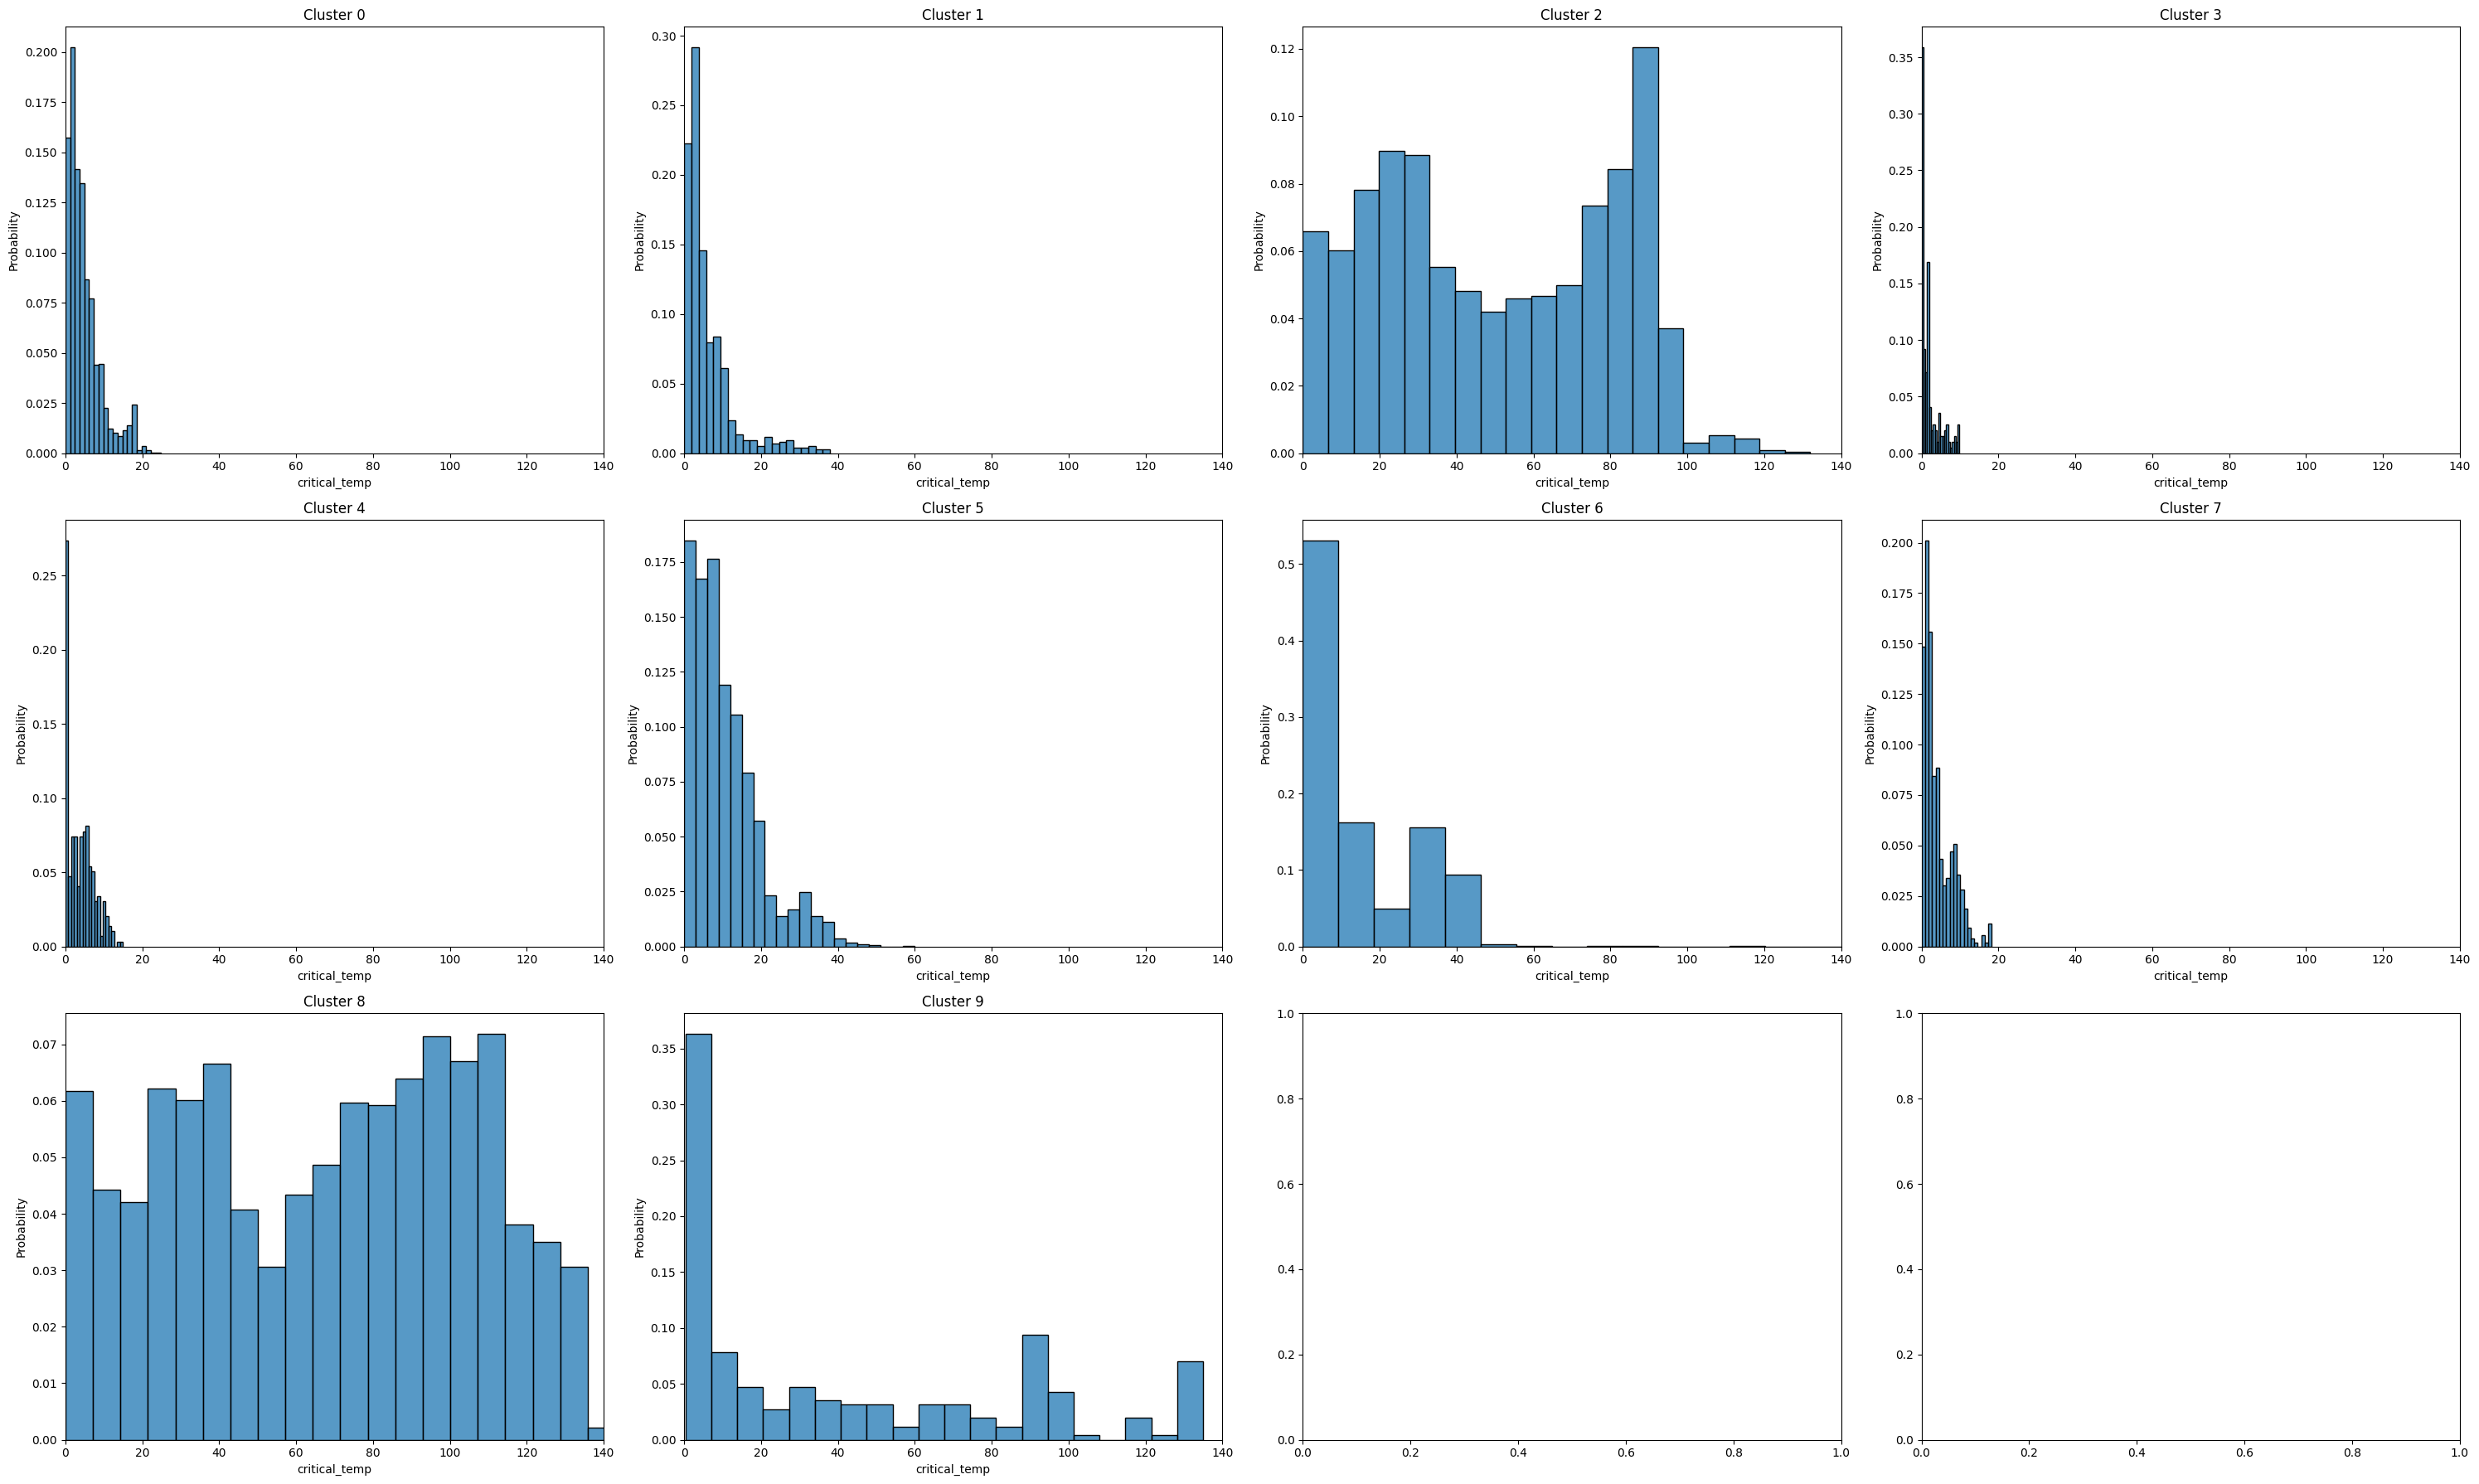

In [10]:
fig, axs = plt.subplots(3, 4, figsize=(30, 18))
axs = axs.flatten()

count = 0
for cluster in valid_clusters: 
    idx = np.where(cluster_labels == cluster)[0]

    X_cluster = X_train.iloc[idx]
    y_cluster = y_train.iloc[idx]

    sns.histplot(y_cluster, ax=axs[count], kde=False, stat="probability", bins=20)  
    axs[count].set_title(f"Cluster {cluster}")
    axs[count].set_xlim(0, 140)

    count += 1
    if count >= len(X_train.columns): 
        break

plt.tight_layout()
plt.show()


Using the same X-axis interval for all the plots, it is clear that the distributions are very different. However, the ranges used are not well defined, so it is not possible to identify the clustering criteria based on this plot alone.

So, some other tools can be used for that type of analysis.

In the reference [1] a method that combines different interpretable measures, as Shapley additive explanations (SHAP), permutation feature importance and quantitatively evaluating partial dependence plots (QPDP) was used for safety climate analysis. Similarly, we can implement these ideas in this case.

First of all, in GLM case, we can edit the original script to verify the most import features for each cluster.

In [11]:
import sys
sys.path.append('..//Main_Scripts')

from script_glm_interpretability import *

In [12]:
glm = Clustering_GLM(clusterer=clone(birch_glm),
                    distribution = sm.families.Gaussian(link=Identity())
    )

In [13]:
glm.fit(X_train, y_train)

,clusterer,Birch(branchi...1719168858943)
,distribution,<statsmodels....001E7B6CA16C0>
,threshold,0.18251719168858943
,branching_factor,700
,n_clusters,10
,compute_labels,True
,copy,'deprecated'


Let´s test!

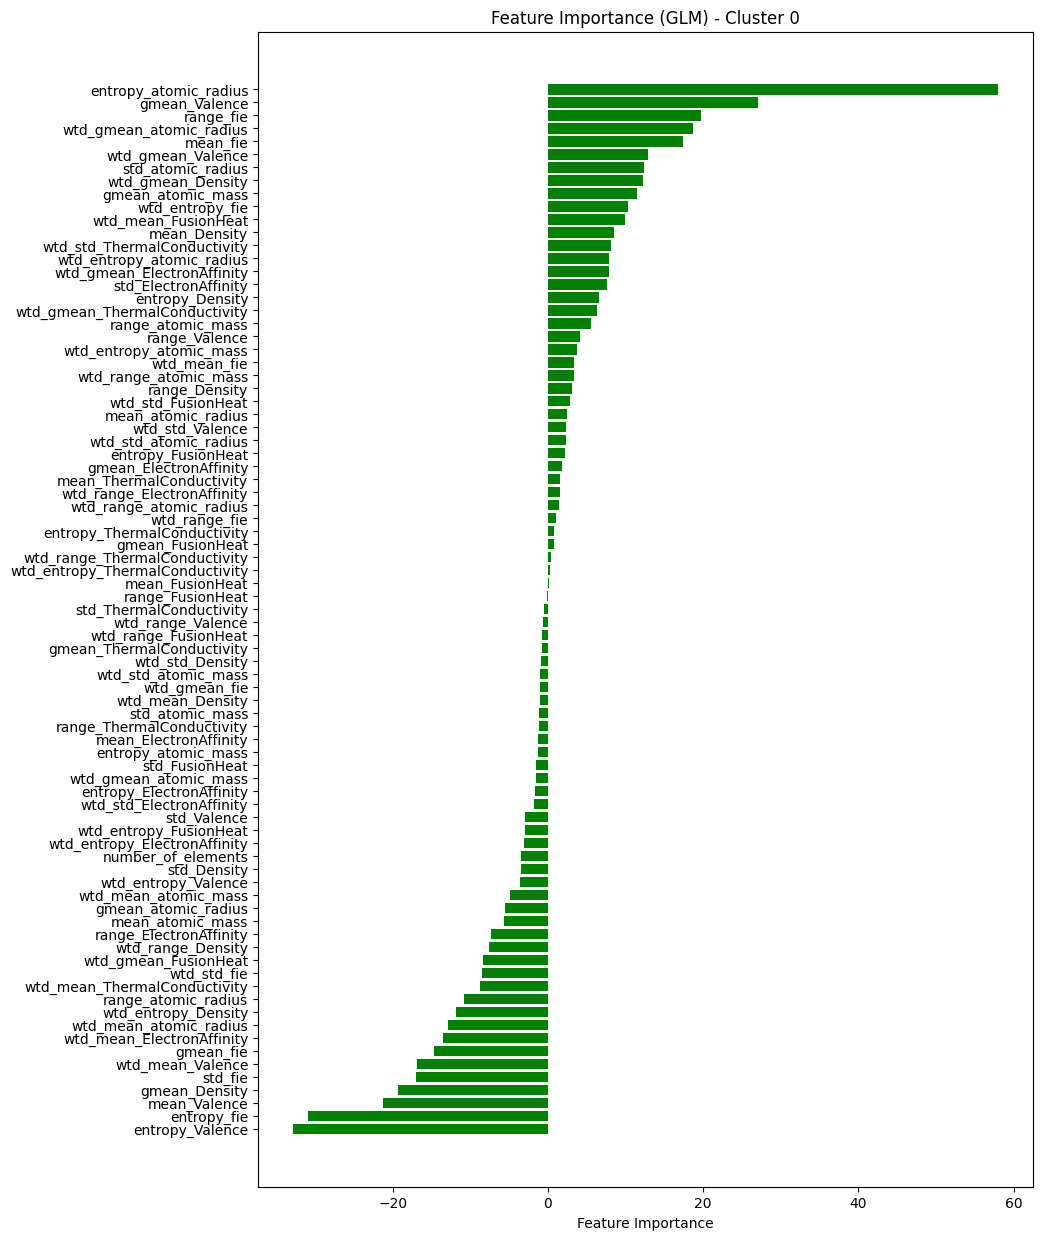

,Feature,Feature Importance
0,number_of_elements,3.450680
1,mean_atomic_mass,5.628531
2,wtd_mean_atomic_mass,4.873541
3,gmean_atomic_mass,11.479187
4,wtd_gmean_atomic_mass,1.561775
5,entropy_atomic_mass,1.293836
6,wtd_entropy_atomic_mass,3.758143
7,range_atomic_mass,5.532258
8,wtd_range_atomic_mass,3.330186
9,std_atomic_mass,1.098564


In [14]:
df_fi0 = glm.feature_importance(cluster=0, k=10)
display(df_fi0)

Here, we can visualize the weight of each feature within a cluster and identify the top-$k$ most important ones, defined by the absolute value of their weights.

We can do this now with the other clusters! By that, we can visualize the plots and, after that, make an histogram with the most frequent features, considering all the clusters. 

In [15]:
df_fi = df_fi0.copy()

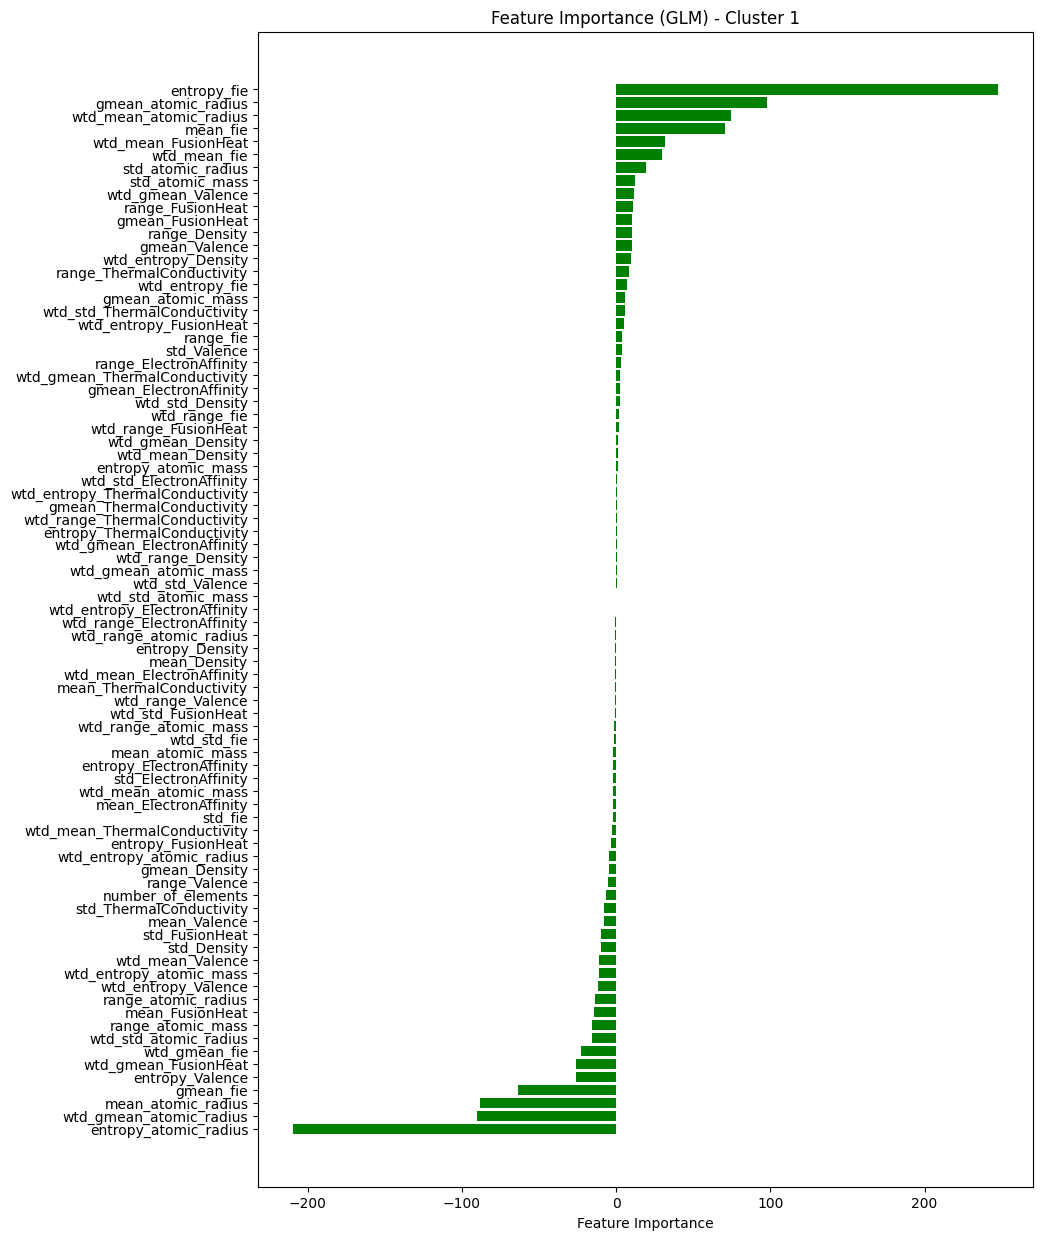

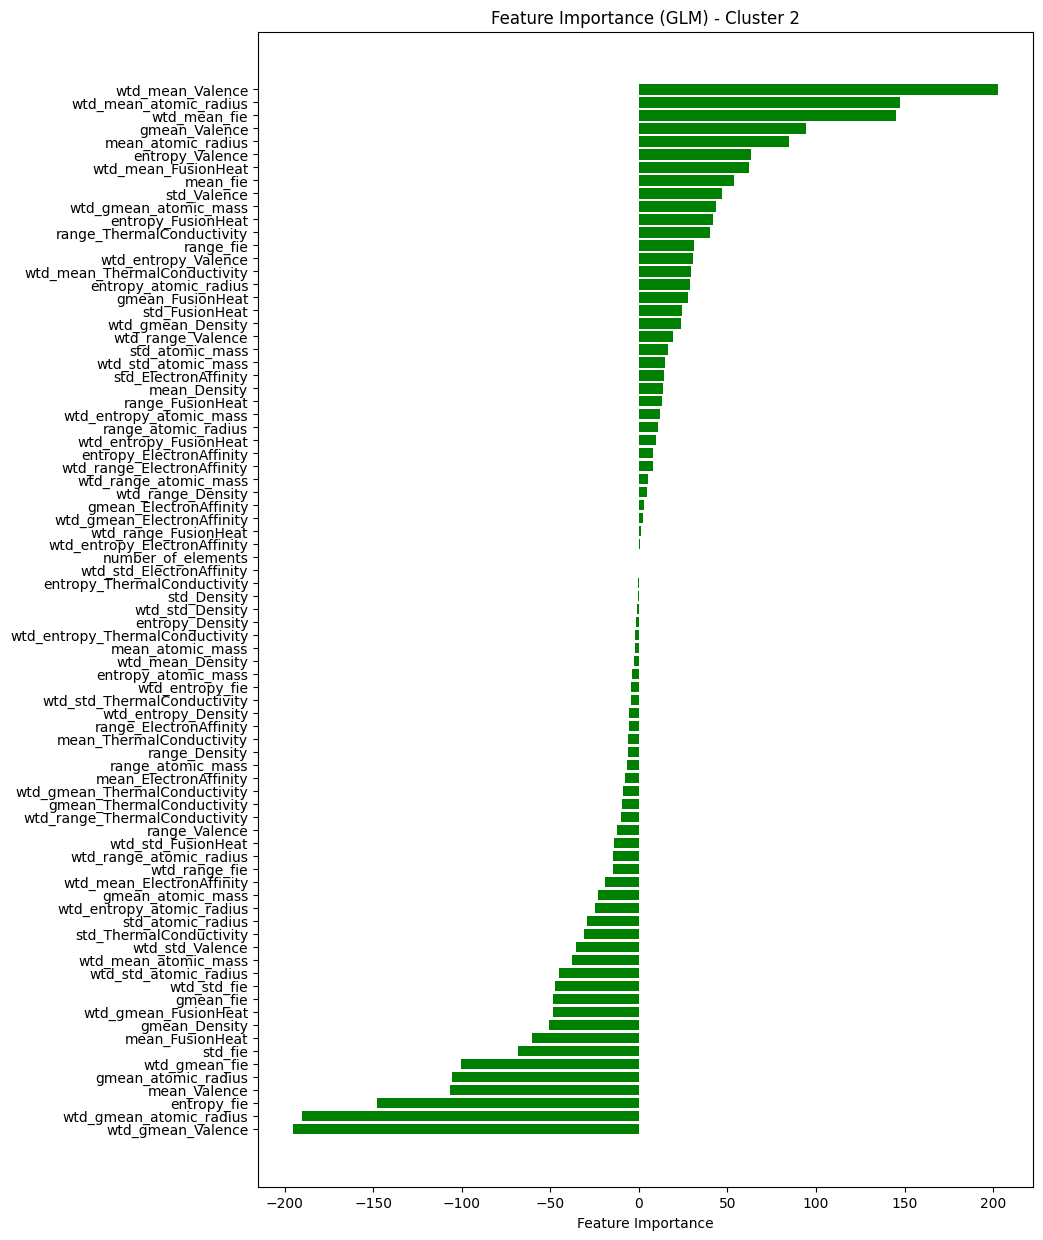

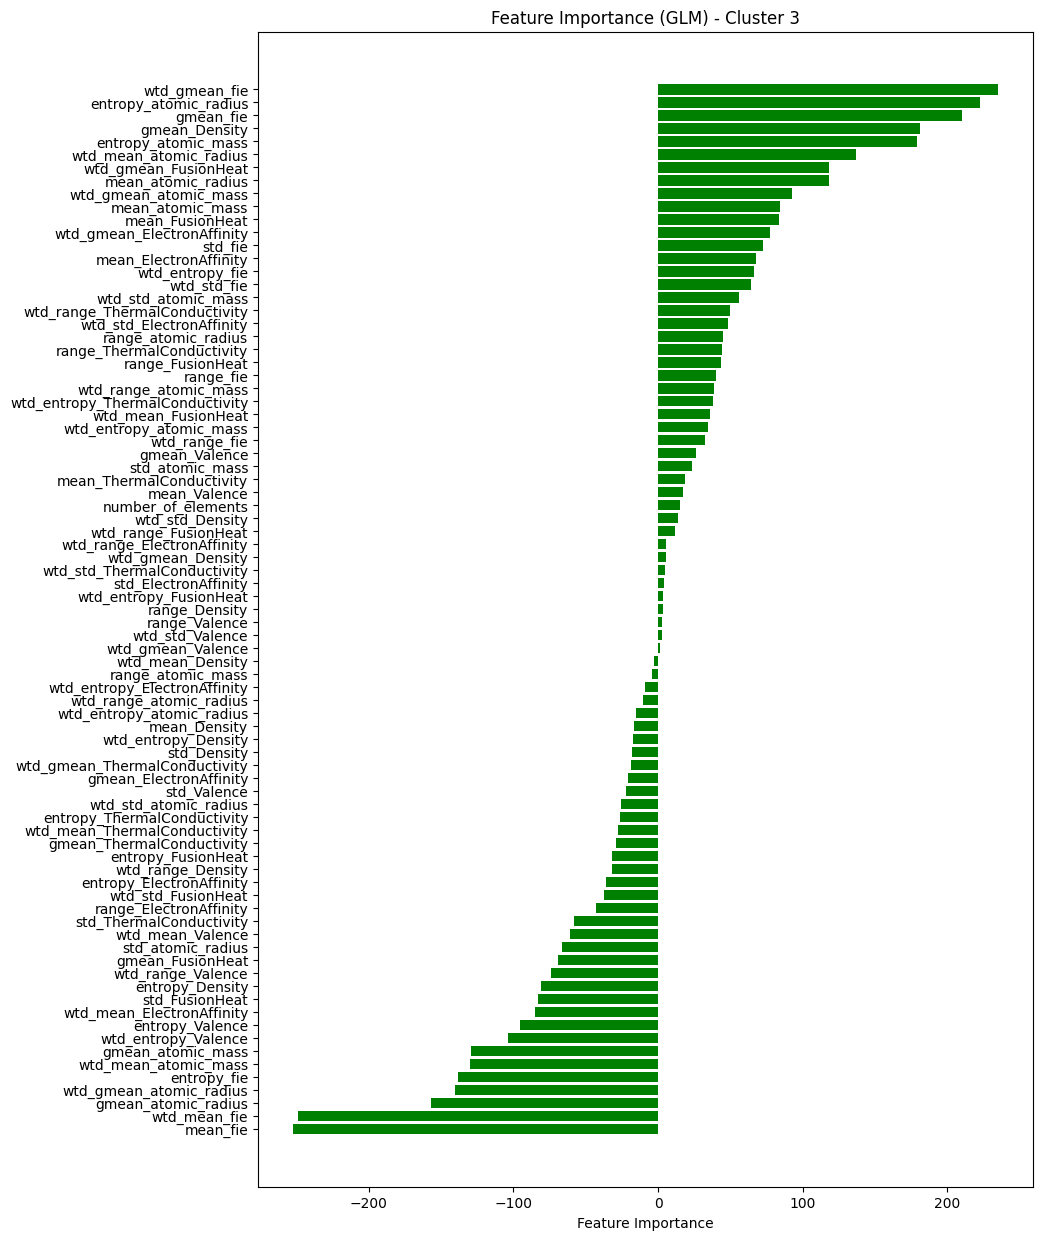

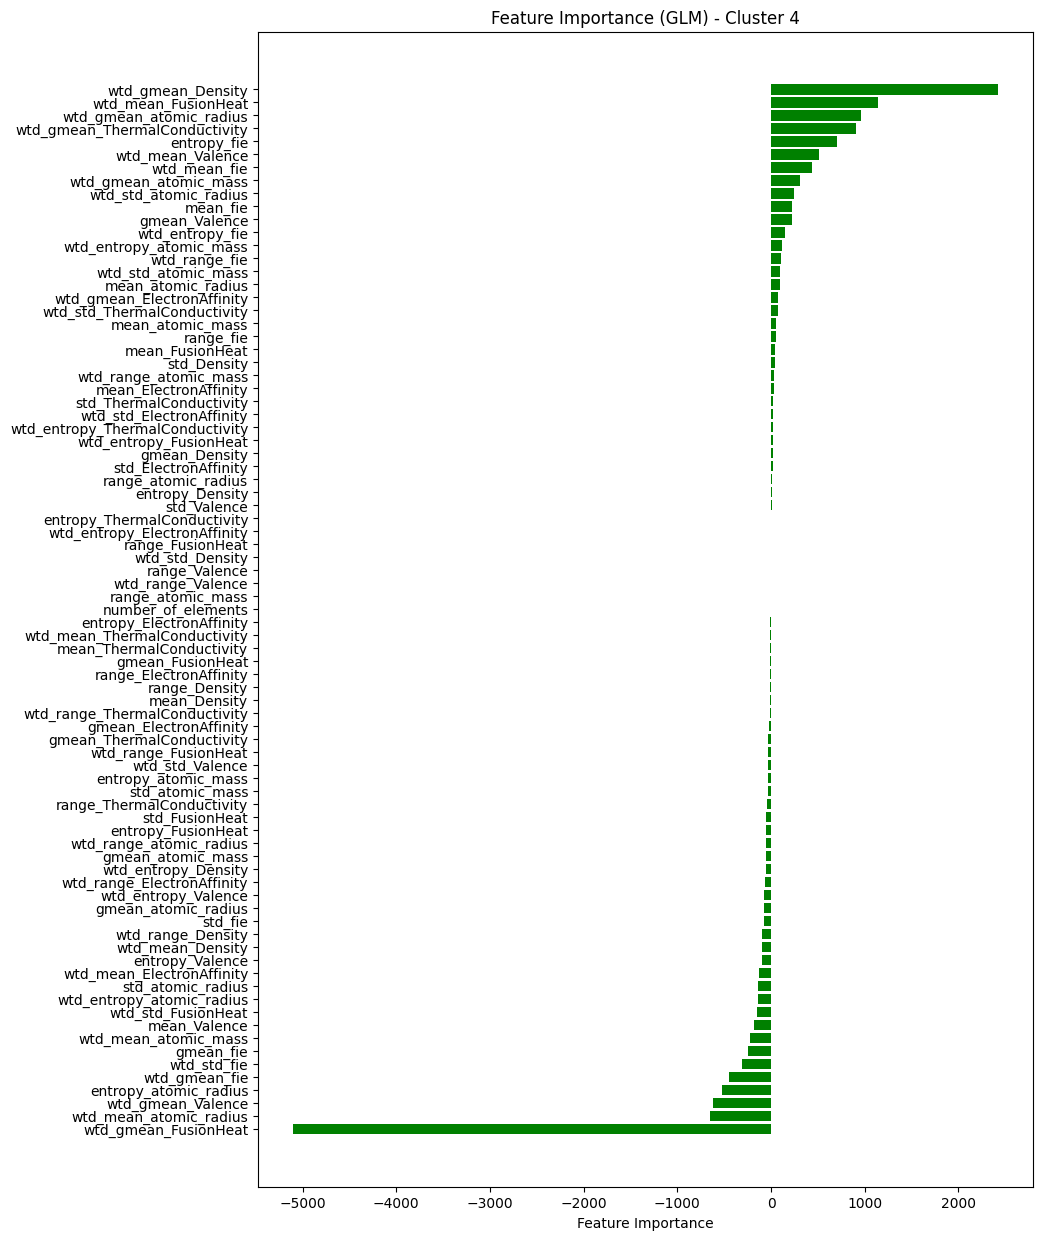

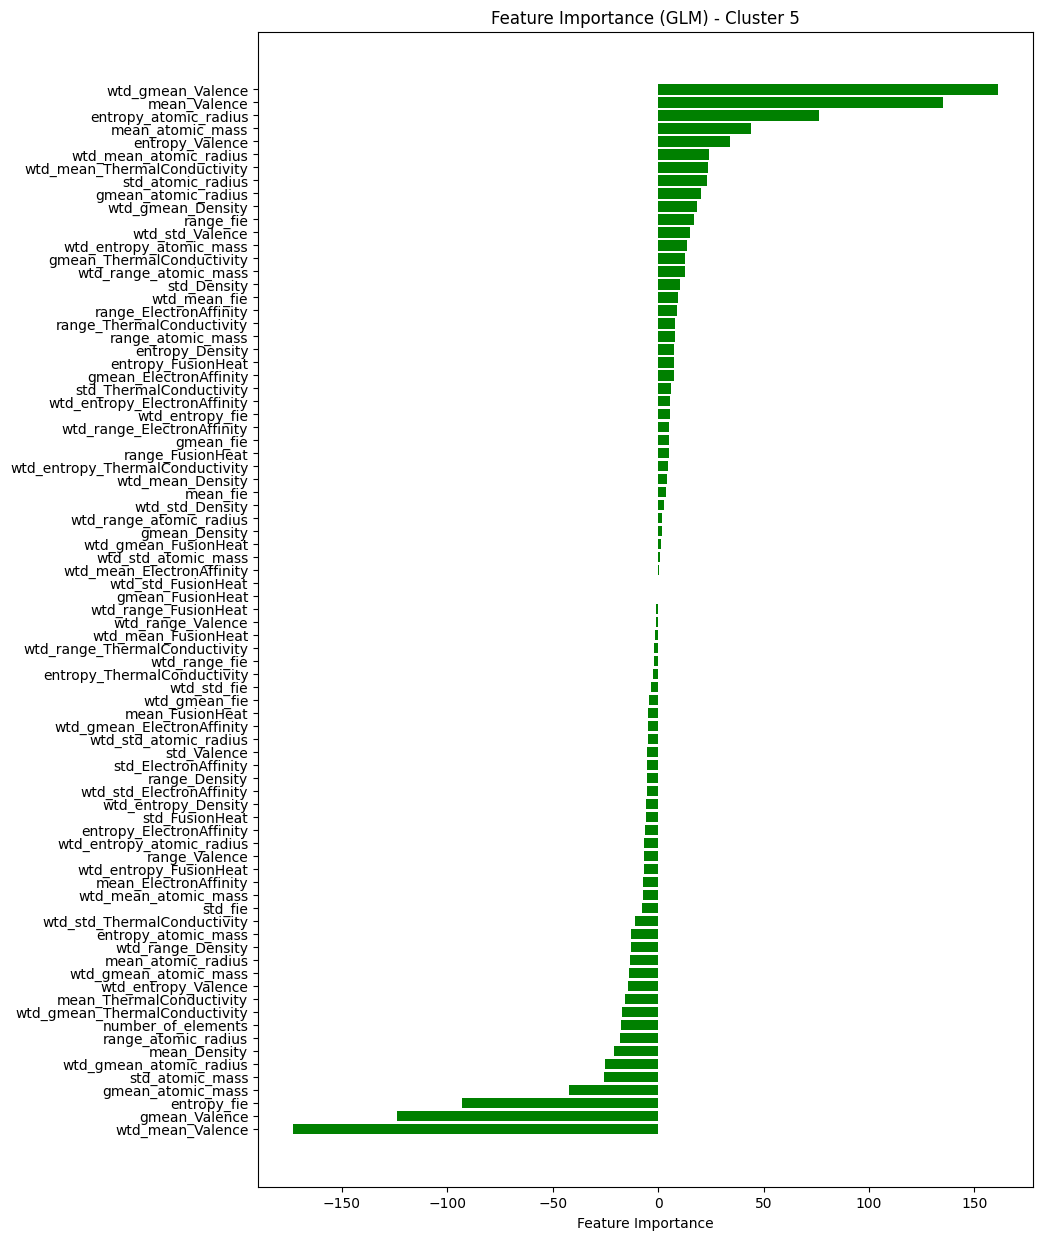

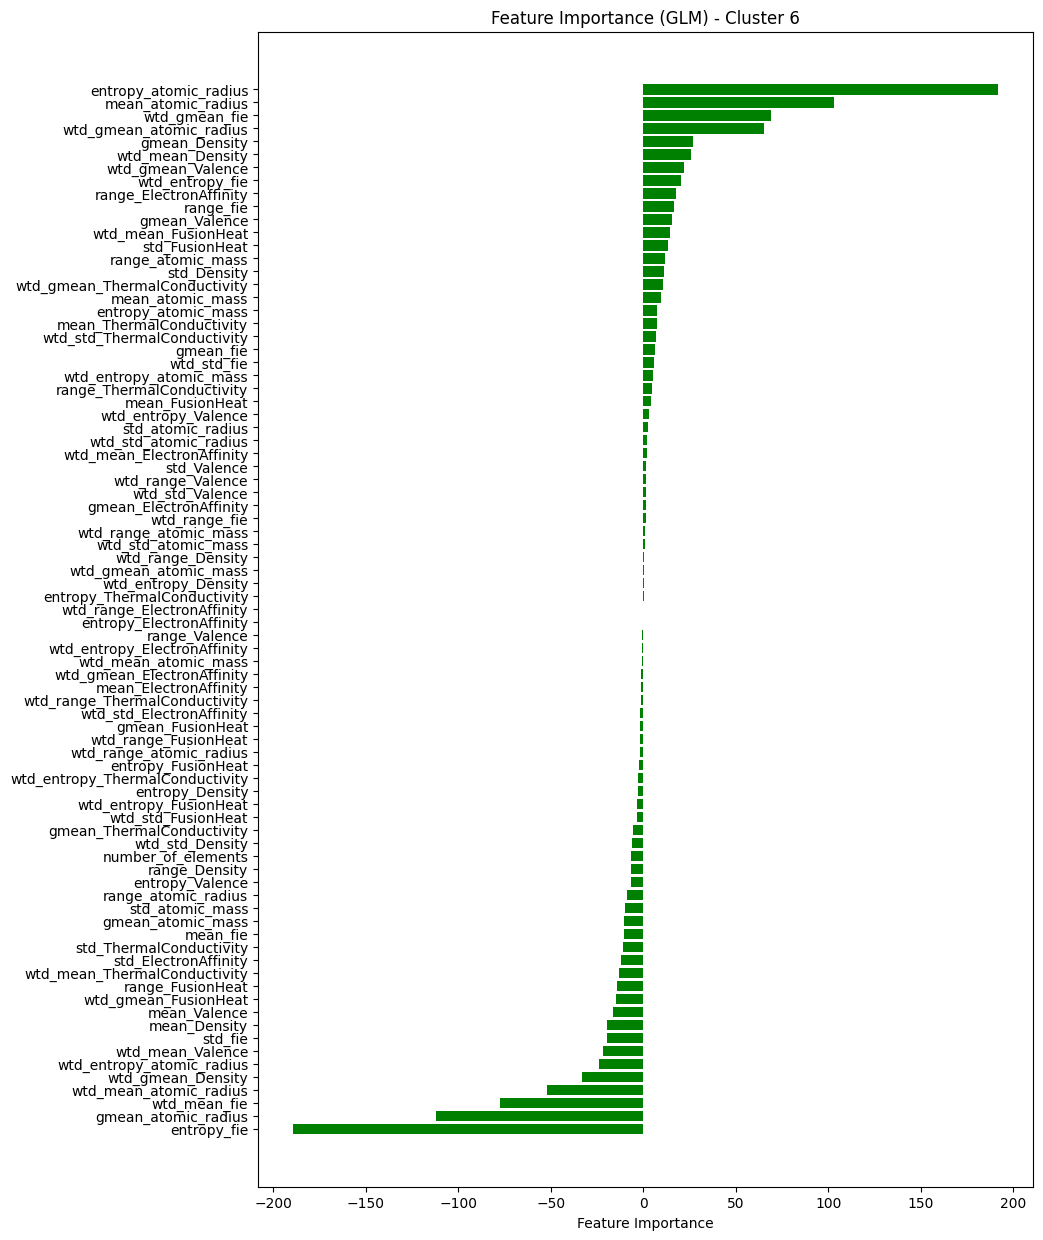

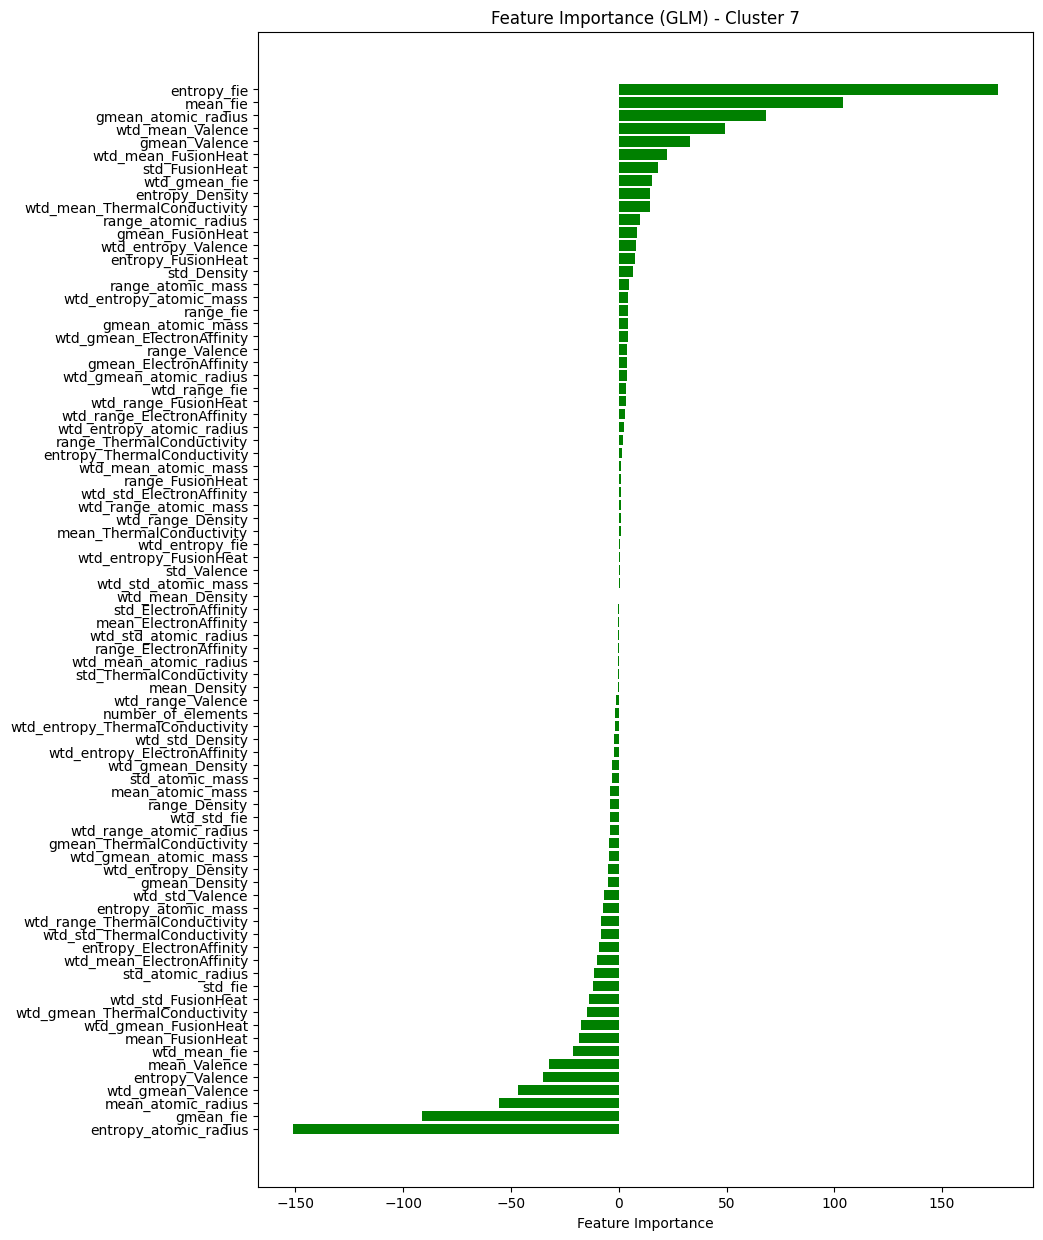

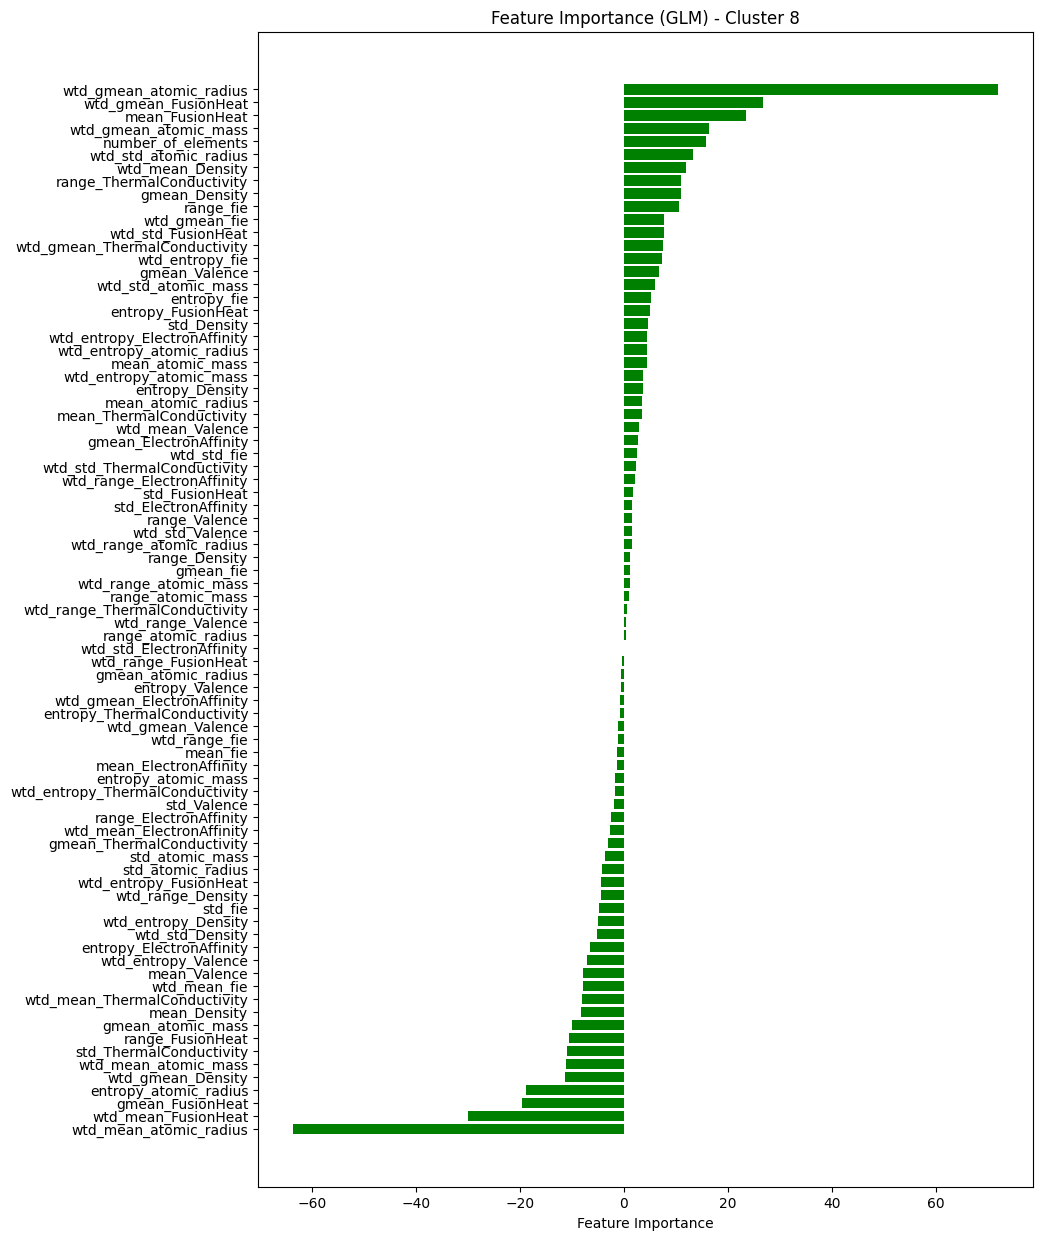

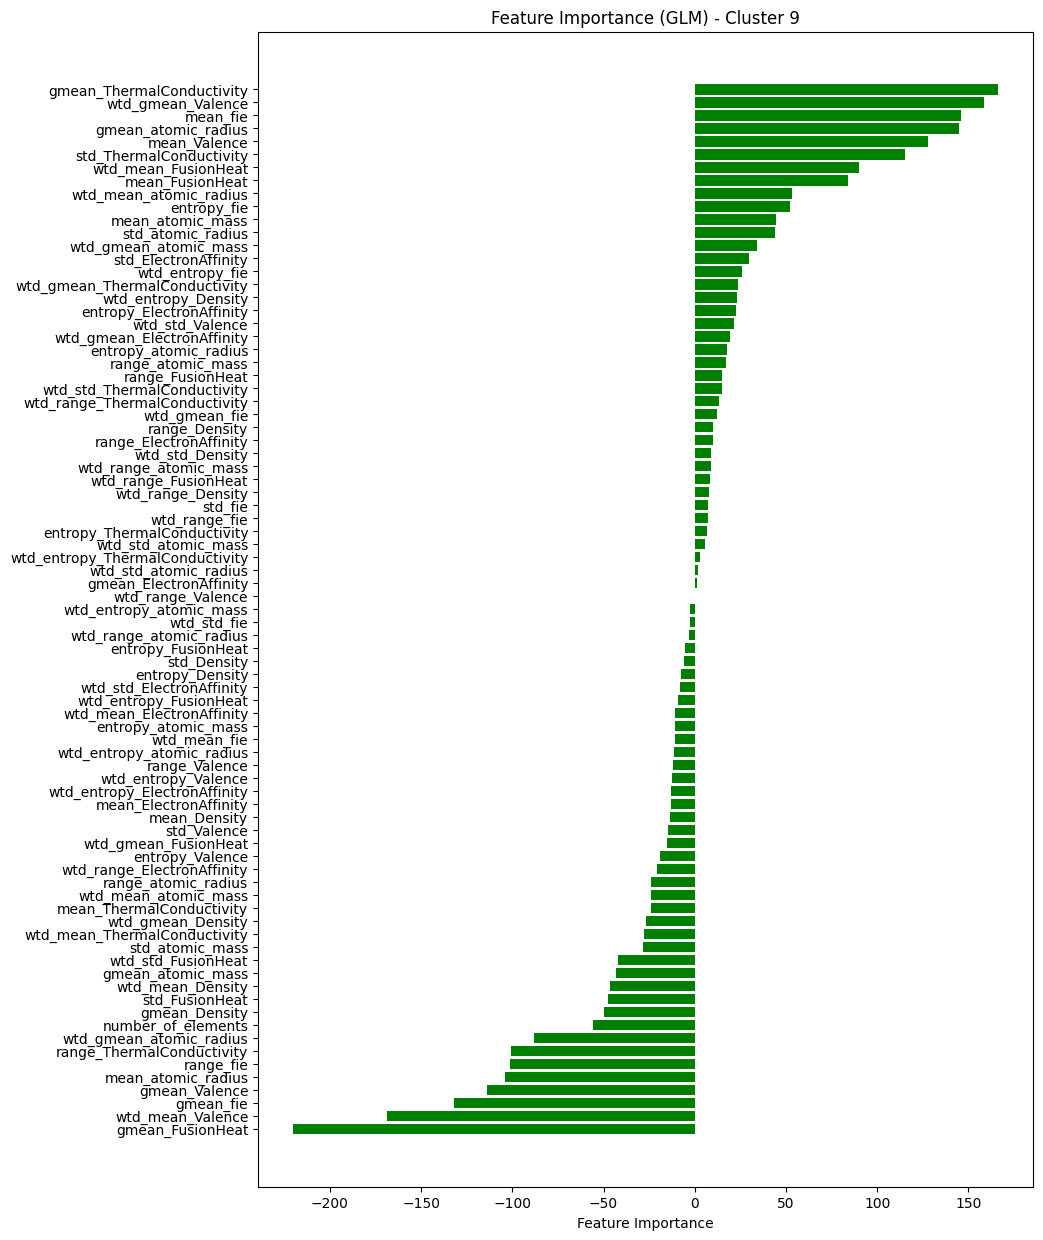

In [16]:
for cluster in valid_clusters[1:]:
    df_fi_per_cluster = glm.feature_importance(cluster=cluster, k=10)
    df_fi = pd.concat([df_fi, df_fi_per_cluster])

In [21]:
df_fi.head(20)

,Feature,Feature Importance
0,number_of_elements,3.450680
1,mean_atomic_mass,5.628531
2,wtd_mean_atomic_mass,4.873541
3,gmean_atomic_mass,11.479187
4,wtd_gmean_atomic_mass,1.561775
5,entropy_atomic_mass,1.293836
6,wtd_entropy_atomic_mass,3.758143
7,range_atomic_mass,5.532258
8,wtd_range_atomic_mass,3.330186
9,std_atomic_mass,1.098564


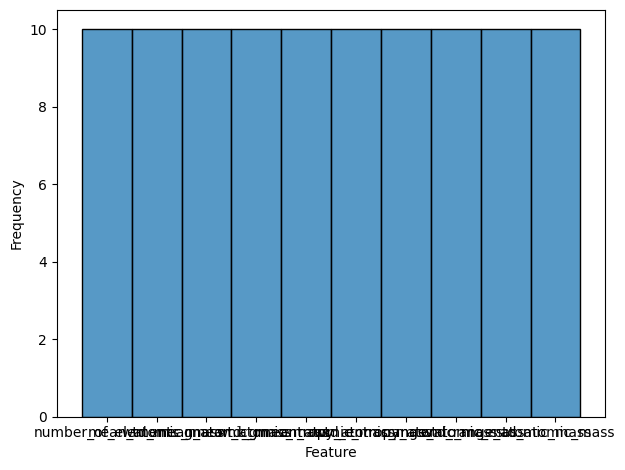

In [20]:
sns.histplot(df_fi["Feature"], kde=False, stat="frequency")  

plt.tight_layout()
plt.show()

It´s interesting to notice that the feature that was considered as the most important, in a expressive way, for the model with all instances (``range_Thermal_Conductivity``) was not considered as the most important feature for any of the clusters! 

### 🗂️ **References!**

[1] Sun, K., Lan, T., Goh, Y. M., Safiena, S., Huang, Y.-H., Lytle, B., & He, Y. (2024). An interpretable clustering approach to safety climate analysis: Examining driver group distinctions. Accident Analysis & Prevention, 196, 107420. https://doi.org/10.1016/j.aap.2023.107420